In [206]:
from matplotlib.pylab import *
from matplotlib import pyplot as plt
import numpy as np
import cv2
from collections import defaultdict

1. Считать цветное rgb изображение

In [207]:
def plt_show_img(img, is_gray = False):
    axis("off")
    imshow(img, cmap = plt.get_cmap('gray') if is_gray else None)

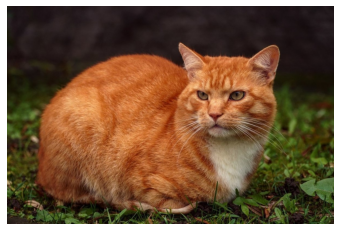

In [208]:
IMG_PATH = "./kitty4.jpg"

img = cv2.cvtColor(cv2.imread(IMG_PATH), cv2.COLOR_BGR2RGB)
plt_show_img(img, False)

In [209]:
img.shape

(800, 1200, 3)

2. Зашумить изображение аддитивным шумом с вероятностью p=0,1

In [210]:
def img_gaussian_noise(rgb_img, p=0.1):
    result = rgb_img.copy()
    rng = np.random.default_rng(54378643684727644864326634562)
    m, n, k = result.shape
    gaussian = np.random.normal(25, 20, (m, n, k)).reshape(m, n, k).astype(uint8)
    r_x = rng.choice(m, int(m*(1-p)))[:, np.newaxis, np.newaxis]
    r_y = rng.choice(n, int(n*(1-p)))[np.newaxis, :, np.newaxis]
    gaussian[r_x, r_y] = gaussian[r_x, r_y] * 0
    
    result = cv2.add(result, gaussian)
    return result

In [211]:
img_noisy = img_gaussian_noise(img)

In [212]:
%matplotlib inline

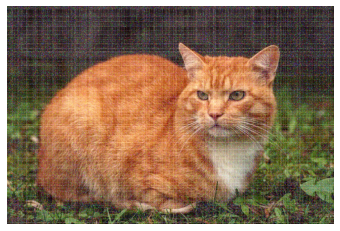

In [213]:
plt_show_img(img_noisy)

3. Написать функцию реализации ранговой фильтрации вида fun(Image, window, rank), где window - окно фильтрации (по вариантам), rank - опциональный параметр, значение ранга в ранговой фильтрации

In [103]:
window=np.array([[1,1,1],[1,3,1],[1,1,1]])
flat_win = window.flatten()
rank=4
win_x, win_y = window.shape
img_x, img_y, img_z = img.shape
img_sliding_window = np.lib.stride_tricks.sliding_window_view(np.pad(img, [(1,1),(1,1),(0,0)], mode='constant'), (win_x, win_y, 3))
fil_x, fil_y, fil_z, win_x, win_y, img_z = img_sliding_window.shape
img_sliding_window = img_sliding_window.reshape((fil_x*fil_y*fil_z, win_x*win_y, img_z))
img_sliding_window.shape
#sorted_index = ((0.3*img_sliding_window[:,:,0] + 0.59*img_sliding_window[:,:,1] + 0.11*img_sliding_window[:,:,2])*flat_win).flatten().argsort()
test_slice = img_sliding_window#[0:2].copy()
test_slice_sum = ((test_slice[:] * [0.3, 0.59, 0.11]).astype(uint8).sum(axis=2)*flat_win).argsort()[:,rank]#.reshape(test_slice.shape[0], 1)
#test_slice_sum[:,rank].reshape(test_slice.shape[0], 1)
test_slice[np.arange(test_slice.shape[0]), test_slice_sum].reshape(img.shape).shape

(800, 1200, 3)

In [214]:
def img_rank_filter(img, window=np.array([[1,1,1],[1,3,1],[1,1,1]]), rank=4):
    win_x, win_y = window.shape
    img_x, img_y, img_z = img.shape
    img_sliding_window = np.lib.stride_tricks.sliding_window_view(np.pad(img, [(1,1),(1,1),(0,0)], mode='constant'), (win_x, win_y, 3))
    fil_x, fil_y, fil_z, win_x, win_y, img_z = img_sliding_window.shape
    img_sliding_window = img_sliding_window.reshape((fil_x*fil_y*fil_z, win_x*win_y, img_z))
    flat_win = window.flatten()
    ind_y = ((img_sliding_window[:] * [0.3, 0.59, 0.11]).astype(uint8).sum(axis=2)*flat_win).argsort()[:,rank]
    return img_sliding_window[np.arange(img_sliding_window.shape[0]), ind_y].reshape(img.shape)

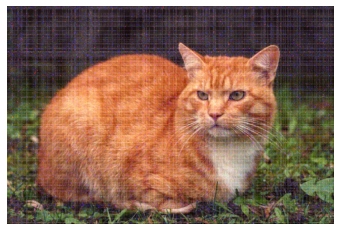

In [215]:
img_filtered = img_rank_filter(img_noisy)
plt_show_img(img_filtered)

4. Отфильтровать зашумленное изображение со всеми возможными рангами (кол-во рангов зависит от окна по вариантам). Подсчитать СКО для результата фильтрации с каждым рангом:

    - __Вход__: изображение из пункта 2.
    - __Выход__: значения СКО для каждого ранга. Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованные изображения для первого, последнего ранга, а так же для ранга с наименьшим СКО.
    - СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1

In [241]:
img_filtered_first = img_rank_filter(img_noisy, rank=0)
img_filtered_last = img_rank_filter(img_noisy, rank=8)
img_filtered_best = img_filtered_first
filtered_best_rank = 0
filtered_std = np.std(img_filtered_first)
for i in range(9):
    filtered = img_rank_filter(img_noisy, rank=i)
    new_std = np.std(filtered)
    print('Rank: ' + str(i) + ', std: ' + str(new_std))
    if new_std < filtered_std:
        filtered_best_rank = i
        filtered_std = new_std
        img_filtered_best = filtered
print('Best results with rank ', filtered_best_rank)

Rank: 0, std: 53.77549936115175
Rank: 1, std: 55.70325671333776
Rank: 2, std: 57.30777321389669
Rank: 3, std: 59.13354975518294
Rank: 4, std: 62.278972912451316
Rank: 5, std: 67.18199635813049
Rank: 6, std: 74.9441354100506
Rank: 7, std: 85.18069726738395
Rank: 8, std: 75.7011380073585
Best results with rank  0


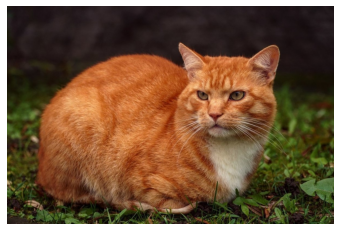

In [226]:
plt_show_img(img)

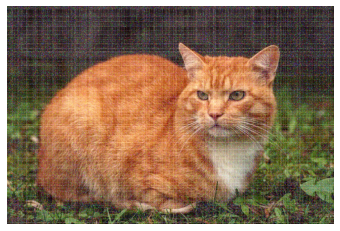

In [227]:
plt_show_img(img_noisy)

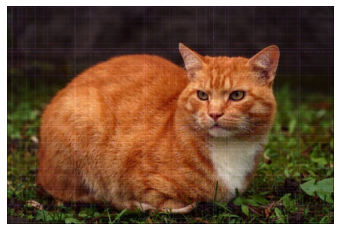

In [228]:
plt_show_img(img_filtered_first)

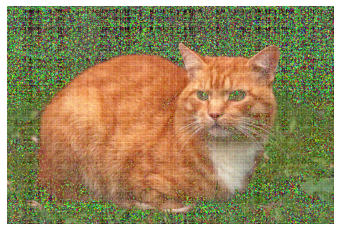

In [229]:
plt_show_img(img_filtered_last)

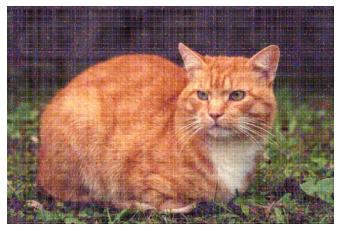

In [240]:
plt_show_img(img_filtered_best)

5. Написать функцию реализации свертки вида fun(mat1, mat2), где mat1 - первый сигнал (изображение), mat2 - второй сигнал (ядро КИХ фильтра).

In [175]:
filter_kernel=np.array([[2,1,2],[1,1,1],[2,1,2]])*(1/13)
win_x, win_y = window.shape
img_x, img_y, img_z = img.shape
img_sliding_window = np.lib.stride_tricks.sliding_window_view(np.pad(img, [(1,1),(1,1),(0,0)], mode='constant'), (win_x, win_y, 3))
fil_x, fil_y, fil_z, win_x, win_y, img_z = img_sliding_window.shape
img_sliding_window = img_sliding_window.reshape((fil_x*fil_y*fil_z, win_x*win_y, img_z))
flat_rev_kernel = np.flip(filter_kernel.flatten())
img_sliding_window = img_sliding_window[0:3]
filtered = ((np.swapaxes(img_sliding_window, 1, 2)*flat_rev_kernel).sum(axis=2)).astype(uint8)
filtered


array([[11, 10,  9],
       [19, 16, 14],
       [18, 16, 14]], dtype=uint8)

In [153]:
def img_fir_filter(img, filter_kernel=np.array([[2,1,2],[1,1,1],[2,1,2]])*(1/13)):
    win_x, win_y = window.shape
    img_x, img_y, img_z = img.shape
    img_sliding_window = np.lib.stride_tricks.sliding_window_view(np.pad(img, [(1,1),(1,1),(0,0)], mode='constant'), (win_x, win_y, 3))
    fil_x, fil_y, fil_z, win_x, win_y, img_z = img_sliding_window.shape
    img_sliding_window = img_sliding_window.reshape((fil_x*fil_y*fil_z, win_x*win_y, img_z))
    flat_rev_kernel = np.flip(filter_kernel.flatten())
    img_sliding_window = img_sliding_window
    return (np.swapaxes(img_sliding_window, 1, 2)*flat_rev_kernel).sum(axis=2).astype(uint8).reshape(img.shape)

6. Отфильтровать изображение КИХ фильтром с ядром заданным по вариантам. Подсчитать СКО. Сравнить с результатами пункта 4.

    - __Вход__: изображение из пункта 2.
    - __Выход__: значения СКО . Исходное (из пункта 1), зашумленное (из пункта 2) и отфильтрованное изображение.
    - СКО считать между отфильтрованным изображением и исходным (не зашумленным) из пункта 1

Orig std: 55.294080023951295


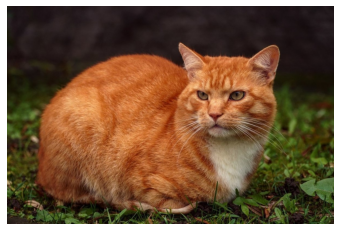

In [244]:
new_std = np.std(img)
print('Orig std: ' + str(new_std))
plt_show_img(img)

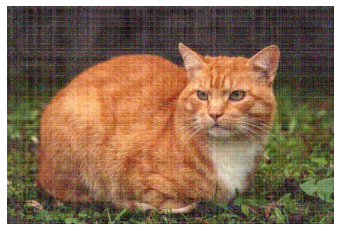

In [195]:
plt_show_img(img_noisy)

FIR filtered std: 54.21058055969202


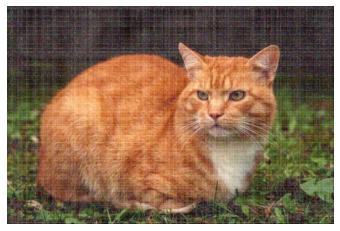

In [242]:
filtered = img_fir_filter(img_noisy)
new_std = np.std(filtered)
print('FIR filtered std: ' + str(new_std))
plt_show_img(filtered)

По результатам выполнения лабораторной работы выяснилось, что лучшее качество даёт фильтрация изображения ранговым фильтром с маской [[1,1,1],[1,3,1],[1,1,1]] и рангом 0.